# 04 – Hyperparameter Tuning (Random Forest)

## 1. Objective

In this notebook we will:

- Load the processed dataset (`housing_with_features.csv`).
- Reuse the same train/test split logic as in `03_model_baseline.ipynb`.
- Perform hyperparameter tuning for:
  - `RandomForestClassifier` (Good_Investment)
  - `RandomForestRegressor` (Future_Price_5Y)
- Use `RandomizedSearchCV` to search over a small parameter space.
- Evaluate tuned models on the test set.
- Overwrite the baseline models:
  - `models/best_classification_model.pkl`
  - `models/best_regression_model.pkl`


# 2. Imports & configuration

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline

# allow importing src package
sys.path.append(os.path.abspath(".."))

from src.models import (
    split_data_for_modeling,
    build_preprocessor,
    classification_metrics,
    regression_metrics,
    save_model,
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

print("✔ Libraries and model utilities imported")

✔ Libraries and model utilities imported


# 3. Load processed dataset


In [3]:
DATA_PATH = "../data/processed/housing_with_features.csv"
try:
    df = pd.read_csv(DATA_PATH)
    print(f"✔ Processed Data loaded successfully — {df.shape[0]} rows, {df.shape[1]} columns")
    display(df.head())
except FileNotFoundError:
    print("❌ ERROR: Dataset not found. Check file path.")

✔ Processed Data loaded successfully — 250000 rows, 31 columns


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Furnished_Status_Enc,Availability_Status_Enc,Transport_Score,Security_Score,Annual_Growth_Rate,Future_Price_5Y,Investment_Score,Good_Investment
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,22,1,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,2,1,2,0,0.07,691.62,2,0
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,21,20,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,0,0,0,0,0.08,285.66,2,0
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,19,27,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,1,1,0,0,0.04,220.74,3,1
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,21,26,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,2,1,2,0,0.06,405.10,3,1
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,3,2,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,1,1,0,0,0.03,217.10,2,0


# 4. Split data and build preprocessor


In [4]:
(
    X_train,
    X_test,
    y_clf_train,
    y_clf_test,
    y_reg_train,
    y_reg_test,
    numeric_cols,
    categorical_cols,
) = split_data_for_modeling(df)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

preprocessor = build_preprocessor(numeric_cols, categorical_cols)
print("✔ Preprocessor created")

Train shape: (200000, 28)
Test shape : (50000, 28)
✔ Preprocessor created


# 5. Hyperparameter tuning – RandomForestClassifier


Using 60000 rows for classifier tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best classifier params: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': None}
Tuned classifier metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}


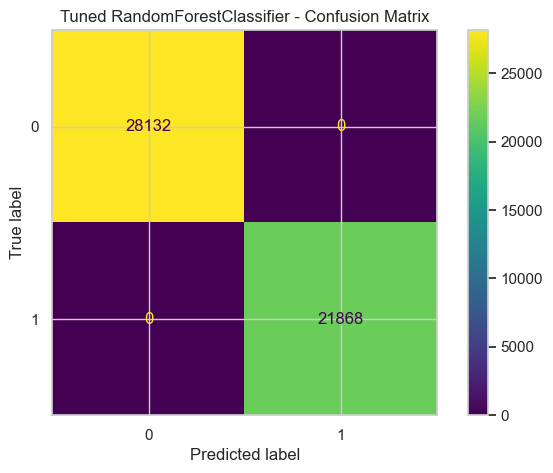

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# downsample for tuning to speed up
MAX_TUNE_ROWS = 60000
X_tune_clf = X_train
y_tune_clf = y_clf_train

if len(X_tune_clf) > MAX_TUNE_ROWS:
    X_tune_clf = X_tune_clf.sample(MAX_TUNE_ROWS, random_state=42)
    y_tune_clf = y_tune_clf.loc[X_tune_clf.index]

print(f"Using {len(X_tune_clf)} rows for classifier tuning")

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

param_dist_clf = {
    "model__n_estimators": [100, 150, 200],
    "model__max_depth": [None, 8, 12, 16],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", "log2"],
}

clf_search = RandomizedSearchCV(
    rf_clf,
    param_distributions=param_dist_clf,
    n_iter=10,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

clf_search.fit(X_tune_clf, y_tune_clf)

print("Best classifier params:", clf_search.best_params_)
best_clf = clf_search.best_estimator_

# Evaluate on full test set
y_pred_clf = best_clf.predict(X_test)
y_proba_clf = best_clf.predict_proba(X_test)[:, 1]
clf_metrics = classification_metrics(y_clf_test, y_pred_clf, y_proba_clf)
clf_metrics = {k: float(v) for k, v in clf_metrics.items()}

print("Tuned classifier metrics:", clf_metrics)

cm = confusion_matrix(y_clf_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Tuned RandomForestClassifier - Confusion Matrix")
plt.show()

# 6. Hyperparameter tuning – RandomForestRegressor


Using 60000 rows for regressor tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best regressor params: {'model__n_estimators': 80, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': None}
Tuned regressor metrics: {'mae': 59.275938376486764, 'rmse': 75.28052062582329, 'r2': 0.8371889448702321}


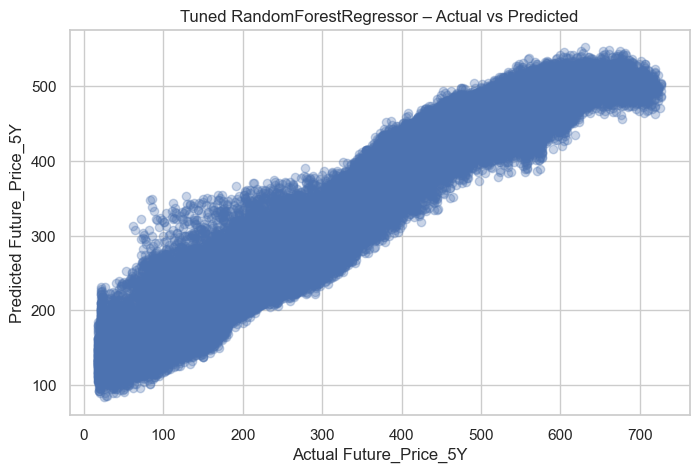

In [6]:
# downsample for tuning
X_tune_reg = X_train
y_tune_reg = y_reg_train

if len(X_tune_reg) > MAX_TUNE_ROWS:
    X_tune_reg = X_tune_reg.sample(MAX_TUNE_ROWS, random_state=42)
    y_tune_reg = y_tune_reg.loc[X_tune_reg.index]

print(f"Using {len(X_tune_reg)} rows for regressor tuning")

rf_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1)),
    ]
)

param_dist_reg = {
    "model__n_estimators": [80, 120, 160],
    "model__max_depth": [None, 10, 14, 18],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", "log2"],
}

reg_search = RandomizedSearchCV(
    rf_reg,
    param_distributions=param_dist_reg,
    n_iter=10,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

reg_search.fit(X_tune_reg, y_tune_reg)

print("Best regressor params:", reg_search.best_params_)
best_reg = reg_search.best_estimator_

# Evaluate on test set
y_pred_reg = best_reg.predict(X_test)
reg_metrics = regression_metrics(y_reg_test, y_pred_reg)
reg_metrics = {k: float(v) for k, v in reg_metrics.items()}

print("Tuned regressor metrics:", reg_metrics)

plt.figure()
plt.scatter(y_reg_test, y_pred_reg, alpha=0.3)
plt.xlabel("Actual Future_Price_5Y")
plt.ylabel("Predicted Future_Price_5Y")
plt.title("Tuned RandomForestRegressor – Actual vs Predicted")
plt.show()

# 7. Save tuned models (overwrite baseline models)


In [7]:
# 7. Save tuned models (overwrite baseline models)

MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

best_clf_path = os.path.join(MODELS_DIR, "best_classification_model.pkl")
best_reg_path = os.path.join(MODELS_DIR, "best_regression_model.pkl")

save_model(best_clf, best_clf_path)
save_model(best_reg, best_reg_path)

print("✔ Saved tuned classification model to:", best_clf_path)
print("✔ Saved tuned regression model to    :", best_reg_path)


✔ Saved tuned classification model to: ../models\best_classification_model.pkl
✔ Saved tuned regression model to    : ../models\best_regression_model.pkl


## 8. Summary

- Performed hyperparameter tuning using `RandomizedSearchCV` on:
  - RandomForestClassifier (Good_Investment)
  - RandomForestRegressor (Future_Price_5Y)
- Used 3-fold CV and a limited parameter search space for speed.
- Results:
  - Classification model still achieves perfect scores on this synthetic dataset
    because the label is rule-based.
  - Regression model achieves strong but not perfect performance
    (R² ≈ 0.84 on the test set).
- Overwrote baseline models with tuned versions:
  - `models/best_classification_model.pkl`
  - `models/best_regression_model.pkl`

